## Mode sources and mode monitors

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FModal_sources_monitors.ipynb).

Here, we look at a simple demonstration of how to excite a specific waveguide mode, and how to decompose the fields recorded in a monitor on the basis of waveguide modes, i.e. how to compute the power carried in each mode.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# tidy3D import
import tidy3d as td
from tidy3d import web

Using Tidy3D credentials from stored file


### Straight waveguide simulation

First, we will do a simulation of a straight waveguide, using a silicon ridge waveguide on a silicon oxide substrate. We begin by defining some general parameters.

In [2]:
# Unit length is micron.
wg_height = 0.22
wg_width = 0.45

# Permittivity of waveguide and substrate
si_eps = 3.48**2
sio_eps = 1.45**2

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction
sim_length = 5
resolution = 50

# Simulation domain size and total run time
sim_size = [sim_length, 4, 2]
run_time = 20/fwidth

### Initialize structures, mode source, and mode monitor

When initializing `ModeSource` and `ModeMonitor` objects, one of the three values of the `size` parameter must be zero. This implicitly defines the propagation direction for the mode decomposition. In this example, the waveguide is oriented along the x-axis, and the mode is injected along the positive-x direction ("forward"). Below, we add a mode monitor that will show us the waveguide transmission at a range of frequencies, as well as a simple frequency monitor to examine the fields in the xy-plane at the central frequency.

In [3]:
# Waveguide and substrate materials
mat_wg = td.Medium(permittivity=si_eps)
mat_sub = td.Medium(permittivity=sio_eps)

# Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size=[td.inf, td.inf, 2*sim_size[2]],
    ),
    medium=mat_sub)

# Waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, 0, wg_height/2],
        size=[100, wg_width, wg_height],
    ),
    medium=mat_wg)

# Modal source parameters
src_pos = -sim_size[0]/2 + 0.5
src_plane = td.Box(center=[src_pos, 0, 0], size=[0, 3, 2])

# xy-plane frequency-domain field monitor at central frequency
freq_mnt = td.FieldMonitor(
    center=[0, 0, wg_height/2],
    size=[100, 100, 0],
    freqs=[freq0],
    name='field')


# frequencies
mon_plane = td.Box(center=[-src_pos, 0, 0], size=[0, 3, 2])
Nfreqs = 21
freqs = np.linspace(freq0 - fwidth, freq0 + fwidth, Nfreqs)
fcent_ind = Nfreqs // 2 # index of the central frequency

# flux monitor
flux_mnt = td.FluxMonitor(
    center=mon_plane.center,
    size=mon_plane.size,
    freqs=list(freqs),
    name='flux'
)

# Modal monitor at a range of frequencies
mode_mnt = td.ModeMonitor(
    center=mon_plane.center,
    size=mon_plane.size,
    freqs=list(freqs),
    mode_spec=td.ModeSpec(num_modes=3),
    name='mode')

Initialize simulation and visualize two cross-sections to make sure we have set up the device correctly.

[09:46:18] WARNING  No sources in simulation.                               ]8;id=370753;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:369

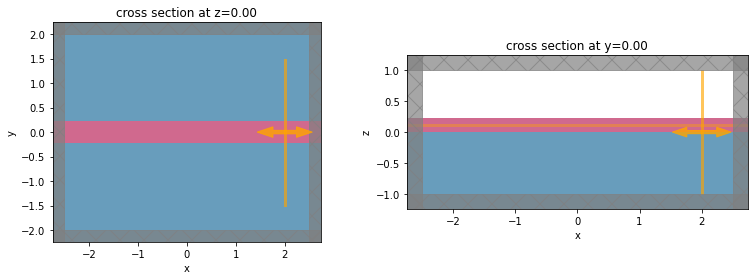

In [4]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_size=3*[1/resolution], 
    structures=[substrate, waveguide], 
    sources=[], 
    monitors=[freq_mnt, mode_mnt, flux_mnt],
    run_time=run_time,
    pml_layers=3*[td.PML()])

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(11, 4))
sim.plot(z=0, ax=ax1);
sim.plot(y=0, ax=ax2);

### Mode source

Before we can run a simulation with a mode source, we have to select which of the eigenmodes we would like to inject. To do that, we can first visualize the modes using the in-built eigenmode solver and plotting functions. The modes are computed at the central frequency of the source, and in order of decreasing effective index `n`, such that the modes that are fully below light-line (if any) should appear first. The solver assumes periodic boundary conditions at the boundaries of the 2D plane. Thus, for accurate results, the plane should be large enough for the fields do decay at the edges.

[09:46:23] WARNING  Mode field at frequency index 0, mode index 2 does not ]8;id=492290;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:418
                    decay at the plane boundaries.

Effective index of computed modes:  [[2.38261287 1.67288328 1.36896762]]


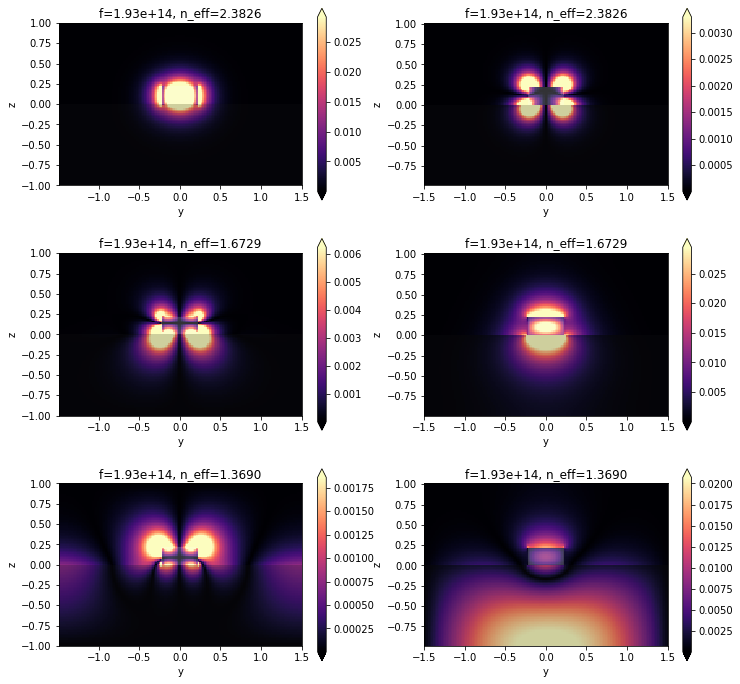

In [5]:
# Visualize the modes
from tidy3d.plugins import ModeSolver

mode_spec = td.ModeSpec(num_modes=3)
ms = ModeSolver(simulation=sim, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for mode_ind in range(3):
    modes.plot_field("Ey", "abs", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    modes.plot_field("Ez", "abs", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])

The waveguide has a single guided TE mode, as well as a TM mode which is very close to the light line (effective index close to substrate index). Finally, the last mode shown here, is below the light-line of the substrate and is mostly localized in that region. However, modes like these should always be considered unphysical, because of the assumption is that they decay by the edges of the mode plane. Thus, for meaningful results, only Mode 0 and Mode 1 should be used by the mode source.

### Run simulation

We set the mode source to the fundamental TE mode. Then, we run the simulation as usual through the web API, wait for it to finish, and download and load the results.

In [6]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=freq0/10)
mode_source = ms.to_source(mode_index=0, direction="+", source_time=source_time)
sim.sources = [mode_source]

In [7]:
job = web.Job(simulation=sim, task_name='mode_tutorial')
sim_data = job.run(path='data/simulation.hdf5')

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[09:47:47] INFO     loading SimulationData from data/simulation.hdf5            ]8;id=996777;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:314

Let's first examine the in-plane fields recorded by the frequency monitor. We can already see how the source emits all of its power in the desired direction and waveguide mode.

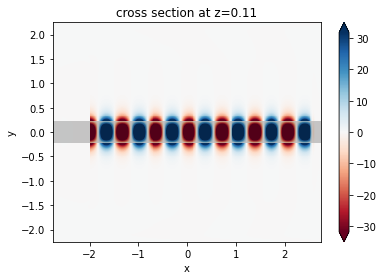

In [8]:
sim_data.plot_field('field', 'Ey', z=wg_height/2, freq=freq0, val='real')
plt.show()

### Mode monitors

Mode monitors allow us to decompose the frequency-domain fields recorded in a simulation into the propagating modes of a waveguide. Specifically, we can write the modes of the waveguide at angular frequency $\omega$ that are propagating in the *forward* direction, i.e. in the positive `x` direction in the example above, as

$$
\mathbf{E}_p^f(\omega, x) = \mathbf{E}_p^f(\omega) e^{i k_p x}, \quad \quad \mathbf{H}_p^f(\omega, x) = \mathbf{H}_p^f(\omega) e^{i k_p x},
$$

where $p$ is a discrete mode index, $k_p = n_p \omega/c$ is the wave-vector, $n_p$ is the effective index of the $p$-th mode, and superscript $f$ specifies forward propagation. The fields in the backward direction can be obtained via reflection symmetry. In the axes of the simulation we have as $k_p \rightarrow -k_p$ and $\mathbf{E}_{p}^b(\omega) = (-E_{p,x}^{f}, E_{p,y}^{f}, E_{p,z}^{f})$, $\mathbf{H}_{p}^b(\omega) = (H_{p,x}^{f}, -H_{p,y}^{f}, -H_{p,z}^{f})$.

The fields stored in a monitor can then be decomposed on the basis of these waveguide modes. Following [1](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.66.066608), [2](https://arxiv.org/abs/1301.5366), we can define an inner product between fields in the 2D plane as

$$
(\mathbf{u}_1, \mathbf{u}_2) = \frac{1}{4} \int_A \left(\mathbf{E}_1^* \times \mathbf{H}_2 + \mathbf{E}_2 \times \mathbf{H}_1^* \right) \cdot \mathrm{d}\mathbf{A},
$$

where $\mathbf{u} = (\mathbf{E}, \mathbf{H})$ combines both electromagnetic fields, the integration is over the plane area $A$, and $\mathrm{d}\mathbf{A}$ is the surface normal. If a waveguide mode is normalized such that $(\mathbf{u}_p, \mathbf{u}_p) = 1$, and we denote the fields stored in the mode monitor by $\mathbf{u}_s$, then the power amplitude carried by mode $p$ is given by the complex coefficient

$$
c_p = (\mathbf{u}_p, \mathbf{u}_s),
$$

while the power is given by $|c_p|^2$.

We can have a look at the monitor modes, but as expected they should be identical to the source modes.

[09:47:54] WARNING  Mode field at frequency index 0, mode index 2 does not ]8;id=705701;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:418
                    decay at the plane boundaries.

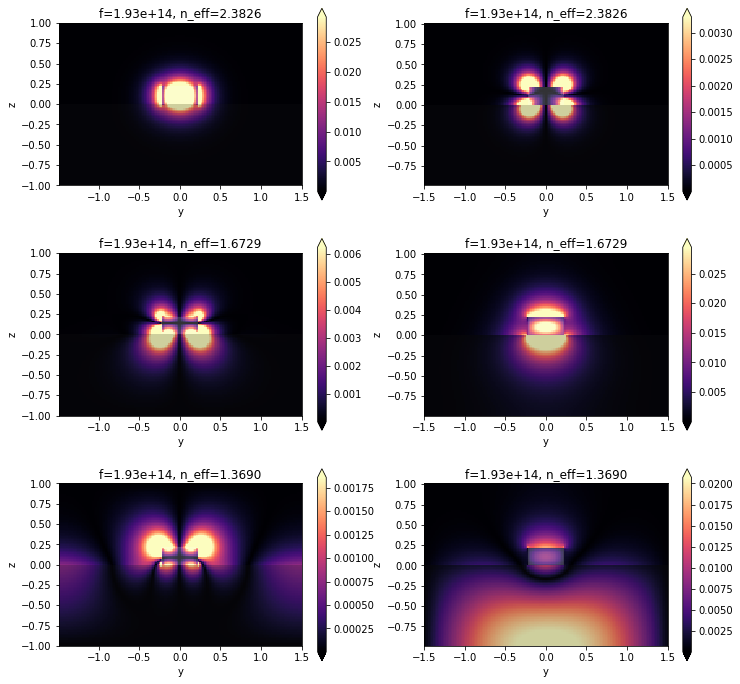

In [9]:
# Visualize the monitor modes
ms = td.plugins.ModeSolver(simulation=sim, plane=mode_mnt.geometry, mode_spec=mode_mnt.mode_spec, freqs=[freq0])
modes = ms.solve()

fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for mode_ind in range(3):
    modes.plot_field("Ey", "abs", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    modes.plot_field("Ez", "abs", freq=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])

We note that in ``Tidy3D``, the fields recorded by frequency monitors (and thus also mode monitors) are automatically normalized by the power amplitude spectrum of the source (for multiple sources, the user can select which source to use for the normalization). Furthermore, mode sources are normalized to inject exactly 1W of power at the central frequency.

In [10]:
# Flux in the mode monitor (total power through the cross-section)
flux_wg = sim_data['flux']
print("Flux at central frequency: ", flux_wg.isel(f=fcent_ind).values)

Flux at central frequency:  0.9999979480365798


We can also use the mode amplitudes recorded in the mode monitor to reveal the decomposition of the radiated power in to forward- and backward-propagating modes, respectively. As we would expect, all of the power is injected into the fundamental waveguide mode, in the forward direction. More precisely, this is true up to some numerical precision that decreases with increasing simulation resolution.

Power distribution at central frequency in first three modes
  positive dir.  [9.99997920e-01 2.74493188e-17 2.86245234e-13]
  negative dir.  [4.26496732e-09 3.76761300e-18 9.26672755e-13]


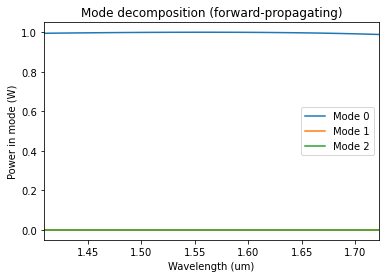

In [11]:
# Forward and backward power amplitude coefficients
mode_amps = sim_data['mode']
coeffs_f = mode_amps.amps.sel(direction="+")
coeffs_b = mode_amps.amps.sel(direction="-")

print("Power distribution at central frequency in first three modes", )
print("  positive dir. ", np.abs(coeffs_f.isel(f=fcent_ind)**2).values)
print("  negative dir. ", np.abs(coeffs_b.isel(f=fcent_ind)**2).values)

# Free-space wavelength corresponding to the monitor frequencies
lambdas = td.C_0 / freqs

fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(lambdas, np.abs(coeffs_f.values)**2)
ax.set_xlim([lambdas[-1], lambdas[0]])
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Power in mode (W)")
ax.set_title("Mode decomposition (forward-propagating)")
ax.legend(["Mode 0", "Mode 1", "Mode 2"])
plt.show()

We can examine the frequency dependence of the results a bit more closely, and compare them to the total power flux, which can be computed for any frequency monitor. The flux is the area-integrated time-averaged Poynting vector and gives the (signed) total power flowing through the surface. The flux computation and the modal decomposition are done in separate monitors and in a completely different way, but because all the power is in the fundamental mode here, the flux matches really well the zero-mode power from the power decomposition.

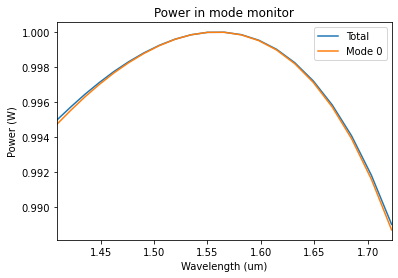

In [12]:
fig, ax = plt.subplots(1, figsize=(6, 4))

ax.plot(lambdas, flux_wg)
ax.plot(lambdas, np.abs(coeffs_f.sel(mode_index=0))**2)
ax.set_xlim([lambdas[-1], lambdas[0]])
ax.set_xlabel("Wavelength (um)")
ax.set_ylabel("Power (W)")
ax.set_title("Power in mode monitor")
ax.legend(["Total", "Mode 0"])

plt.show()

As we already saw, at the central frequency, the source power is extremely well directed in the waveguide mode. Since the source mode is computed at the central frequency only, away from that it is not perfectly matched, leading to a small decrease of the total radiated power. In certain situations, it is even possible to observe injected power larger than one away from the central frequency. That said, we see that all the radiated power is still emitted into the desired waveguide mode, within the wavelength range of interest. For best accuracy when computing scattering parameters away from the central frequency, we then just need to do a “normalization” run with a straight waveguide, like the one we just did, and normalize w.r.t. the computed flux to account for the small frequency dependence of the total radiated power. This is illustrated below.

### Waveguide junction

We repeat the simulation, but this time introduce a much bigger waveguide in the second half of the domain.

In [13]:
# Output waveguide
wgout_width = 1.4

waveguide_out = td.Structure(
    geometry=td.Box(
        center=[2, 0, wg_height/2],
        size=[4, wgout_width, wg_height],
    ),
    medium=mat_wg)

In [14]:
sim2 = td.Simulation(
    size=sim_size,
    grid_size=3*[1/resolution], 
    structures=[substrate, waveguide, waveguide_out], 
    sources=[mode_source],
    monitors=[freq_mnt, mode_mnt, flux_mnt],
    run_time=run_time,
    pml_layers=[td.PML()]*3)

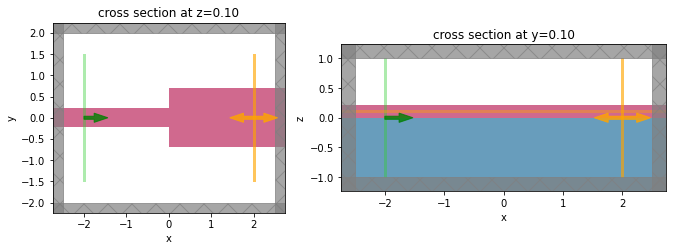

In [15]:
fig = plt.figure(figsize=(11, 4))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1.4])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
sim2.plot(z=0.1, ax=ax1);
sim2.plot(y=0.1, ax=ax2);

In [16]:
job = web.Job(simulation=sim2, task_name='mode_converter')
sim_data = job.run(path='data/mode_converter.hdf5')

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[09:49:15] INFO     loading SimulationData from data/mode_converter.hdf5        ]8;id=989618;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:314

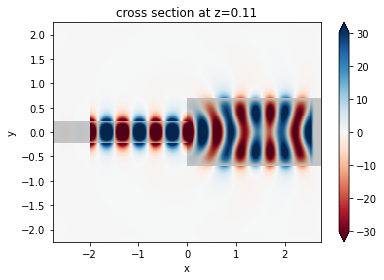

In [17]:
sim_data.plot_field('field', 'Ey', z=wg_height/2, freq=freq0, val='real')
plt.show()

This time, the output waveguide is multi-mode, and there is obviously some mode-mixing happening. We can use the mode monitor to exactly quantify this.

Power distribution at central frequency in first three modes
  positive dir.  [6.99526942e-01 2.59294093e-16 2.62528302e-01]
  negative dir.  [7.44888642e-09 4.44389456e-17 1.68543632e-09]


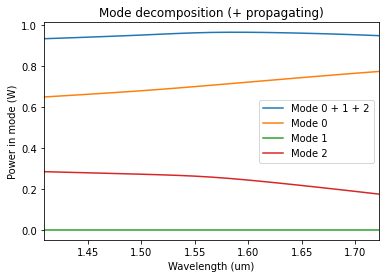

In [18]:
# Forward and backward power amplitude coefficients normalized to the straight waveguide flux
mode_amps = sim_data['mode']
coeffs_f = mode_amps.amps.sel(direction="+") / np.sqrt(flux_wg)
coeffs_b = mode_amps.amps.sel(direction="-") / np.sqrt(flux_wg)

print("Power distribution at central frequency in first three modes", )
print("  positive dir. ", np.abs(coeffs_f.isel(f=fcent_ind)**2).values)
print("  negative dir. ", np.abs(coeffs_b.isel(f=fcent_ind)**2).values)

# Free-space wavelength corresponding to the monitor frequencies
lambdas = td.C_0 / freqs

fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(lambdas, np.sum(np.abs(coeffs_f.values)**2, axis=1))
ax.plot(lambdas, np.abs(coeffs_f.values)**2)
ax.set_xlabel("Wavelength (um)")
ax.set_xlim([lambdas[-1], lambdas[0]])
ax.set_ylabel("Power in mode (W)")
ax.set_title("Mode decomposition (+ propagating)")
ax.legend(["Mode 0 + 1 + 2", "Mode 0", "Mode 1", "Mode 2"])
plt.show()

Because of the symmetry with respect to the $y=0$ plane, the power in Mode 0 cannot be converted to Mode 1, but a significant amount of power is converted to Mode 3. Note also that the combined power in the computed modes is smaller than 1W. The missing part is most likely lost in scattering at the sharp waveguide interface.